<a href="https://colab.research.google.com/github/aaroha33/My-Assignments/blob/main/Tredence_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
<h1 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"><font color="#0239A8" size=+5> <center> Tredence Analytics Assignment </center></h1>



* Your client ABC (manuf_data) came with an ask that they don’t have visibility of the sales on retailer platforms(retailer_data). Reason there is no unique key mapping       product of ABC to its product being sold on retailer (retailer example-Amazon). In the absence of a common primary key, you are left with descriptions to do the mapping. You need to use the description of ABC (manuf_data) and description of its product on retailer platform(retailer_data) to do the mapping
* Map all the retailer product to top 3-4 best possible match on ABC side. Use any NLP technique to the achieve the objective
* Things to keep in mind- we have not provided any training data- please create one if needed, clearly comment your code.





<font color="blue" size=+2.5><b> Import Library </b></font>

In [89]:
import io
import os

import pandas as pd
import seaborn as sns
from PIL import Image
import numpy as np
import itertools
import collections
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.display import display, HTML
import plotly.graph_objects as go


import nltk
from nltk import Text
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import word_tokenize  
from nltk.tokenize import sent_tokenize 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import ToktokTokenizer

import pickle
import gensim

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline




<font color="blue" size=+2.5><b> Upload Data Sets </b></font>

In [90]:
from google.colab import files
uploaded = files.upload()


Saving retailer_data.xlsx to retailer_data (1).xlsx
Saving manuf_data.xlsx to manuf_data (1).xlsx


In [91]:
retail = pd.read_excel(io.BytesIO(uploaded['retailer_data.xlsx']))
mnf = pd.read_excel(io.BytesIO(uploaded['manuf_data.xlsx']))

<font color="blue" size=+2.5><b> EDA </b></font>

In [92]:
retail.head()

ret_prod_id                     Product_Description
0          188  Oddaced Give Me Moisture Shampoo 250ml
1          334      Cbvery Freeze Hold Hairspray 400ml
2          328        Cbvery Firm Hold Hairspray 400ml
3          203   Oddaced Ultimate Hold Hairspray 400ml
4          324       Cbvery Extra Hold Hairspray 400ml

In [93]:
mnf.head()

prod_id                             Description
0      355  Mexifiz Shampoo Intensive Repair 400ml
1      356  Mexifiz Shampoo Intensive Repair 400ml
2      381         Cbv Shampoo Moisture Rich 900ml
3      382         Cbv Shampoo Moisture Rich 900ml
4      426       Cbvery Hairspray Extra Hold 400ml

In [94]:
print(mnf.isnull().sum())
print(retail.isnull().sum())

prod_id        0
Description    0
dtype: int64
ret_prod_id            0
Product_Description    0
dtype: int64


<font color="blue" size=+2.5><b> WORDCLOUD </b></font>

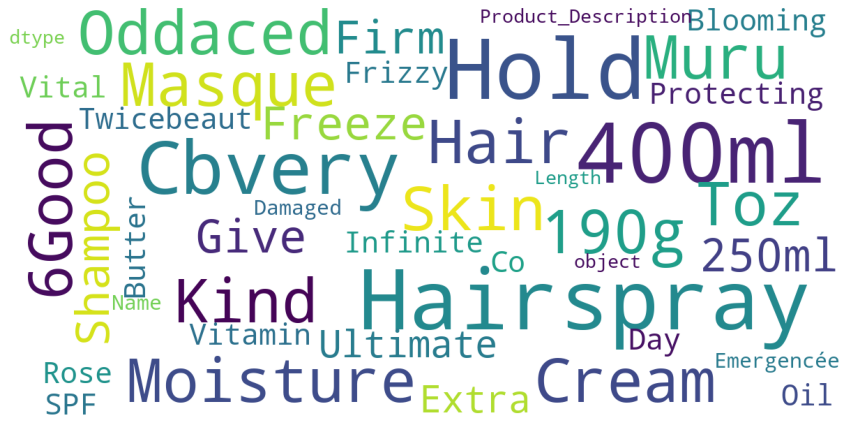

In [180]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(retail['Product_Description'])

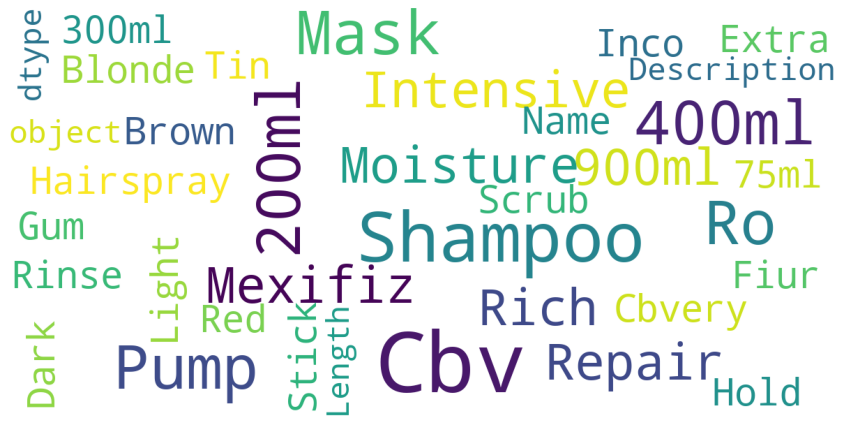

In [179]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(mnf['Description'])

In [97]:
retail['Description_length'] = retail['Product_Description'].apply(len)
#retail['Product_Description_length1'] = [len(t) for t in retail.Product_Description]

In [98]:
retail.head()

ret_prod_id                     Product_Description  Description_length
0          188  Oddaced Give Me Moisture Shampoo 250ml                  38
1          334      Cbvery Freeze Hold Hairspray 400ml                  34
2          328        Cbvery Firm Hold Hairspray 400ml                  32
3          203   Oddaced Ultimate Hold Hairspray 400ml                  37
4          324       Cbvery Extra Hold Hairspray 400ml                  33

### Overall Distribution of the length 

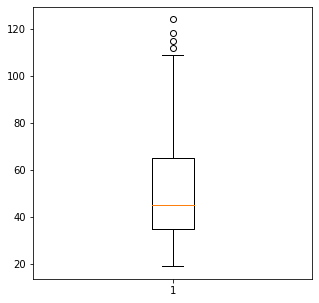

In [99]:
fig,ax = plt.subplots(figsize=(5,5))
plt.boxplot(retail.Description_length)
plt.show()

In [100]:
mnf['Description_length'] = mnf['Description'].apply(len)
mnf.head()

prod_id                             Description  Description_length
0      355  Mexifiz Shampoo Intensive Repair 400ml                  38
1      356  Mexifiz Shampoo Intensive Repair 400ml                  38
2      381         Cbv Shampoo Moisture Rich 900ml                  31
3      382         Cbv Shampoo Moisture Rich 900ml                  31
4      426       Cbvery Hairspray Extra Hold 400ml                  33

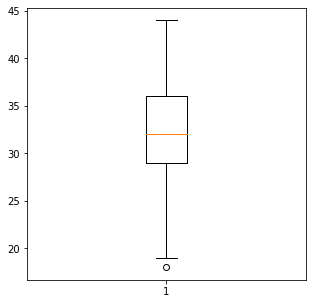

In [101]:
fig,ax = plt.subplots(figsize=(5,5))
plt.boxplot(mnf.Description_length)
plt.show()

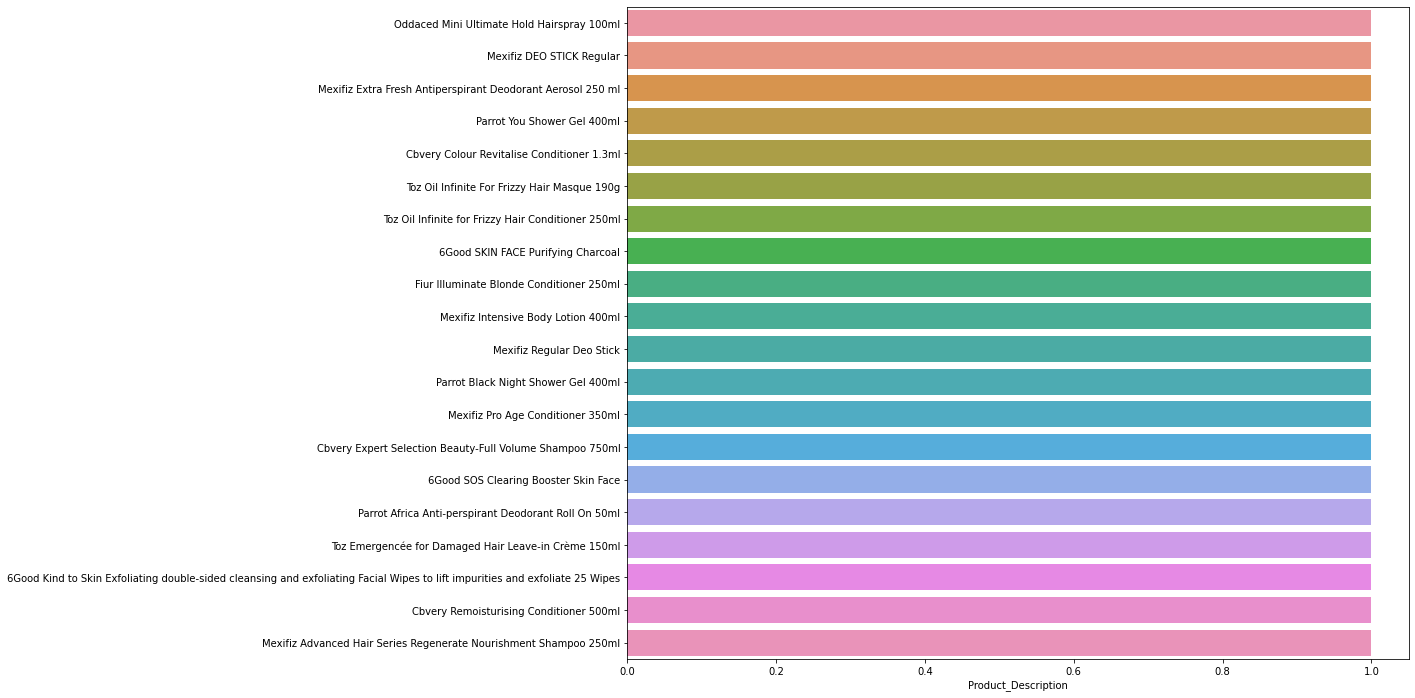

In [102]:
# Plotting the first 20 most common keywords in retail
figure = plt.figure(figsize=(14,12))
sns.barplot(y=retail['Product_Description'].value_counts().index[:20], x=retail['Product_Description'].value_counts()[:20])

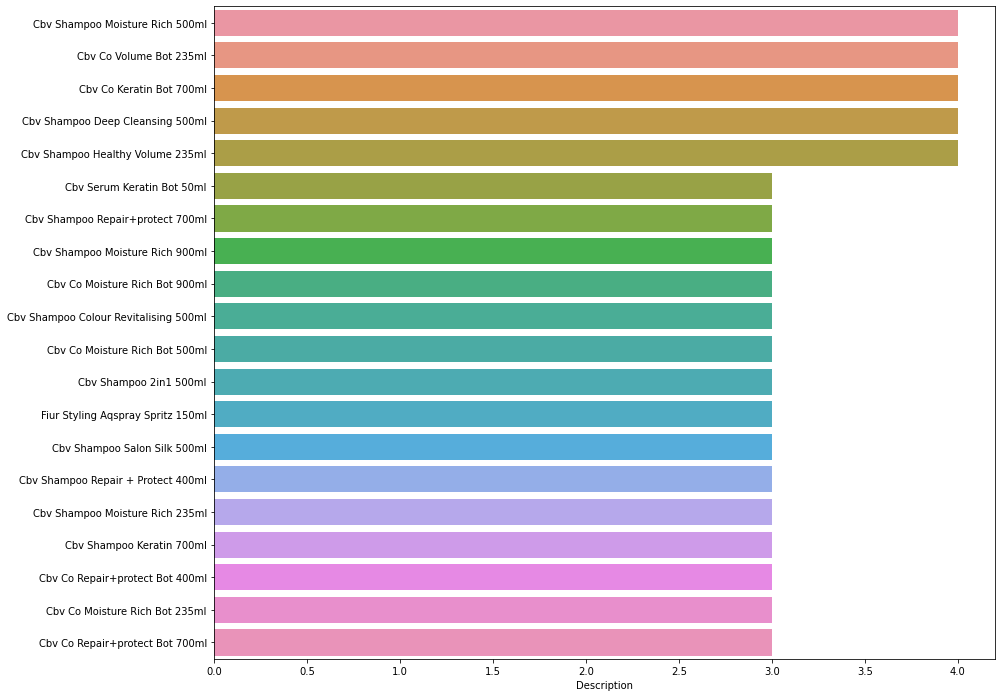

In [103]:
# Plotting the first 20 most common keywords in manufacturing(abc)
figure = plt.figure(figsize=(14,12))
sns.barplot(y=mnf['Description'].value_counts().index[:20], x=mnf['Description'].value_counts()[:20])

**What about frequency of the words?**

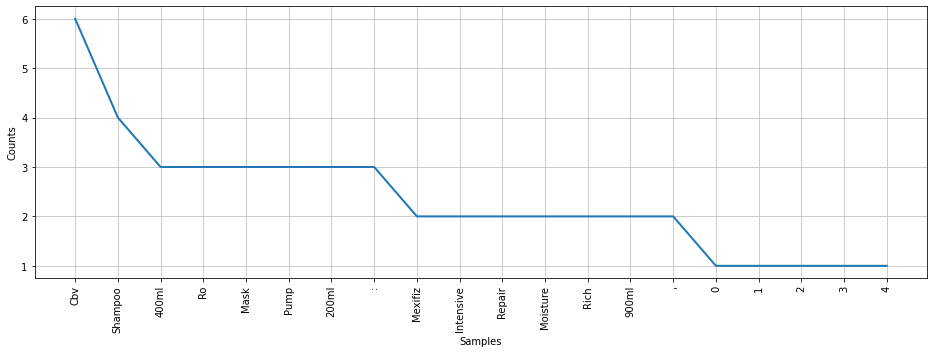

In [104]:
x=nltk.FreqDist(ToktokTokenizer().tokenize(mnf['Description']))
plt.figure(figsize=(16,5))
x.plot(20)

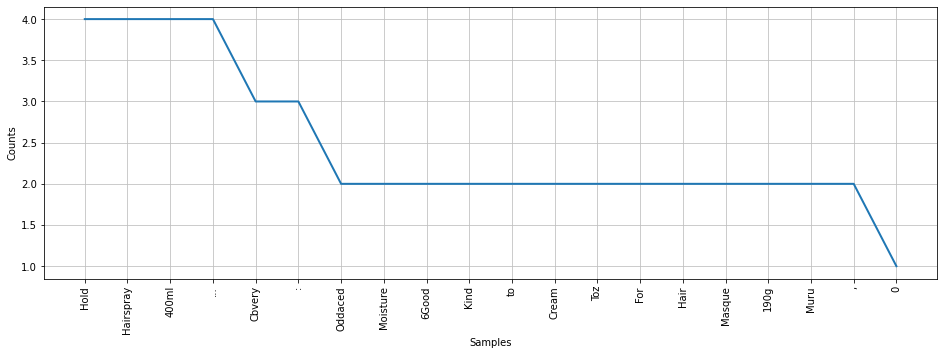

In [105]:
x=nltk.FreqDist(ToktokTokenizer().tokenize(retail['Product_Description']))
plt.figure(figsize=(16,5))
x.plot(20)

### Term Frequencies 

In [106]:
cvector = CountVectorizer(min_df = 0.0, max_df = 1.0, ngram_range=(1,2))
cvector.fit(mnf.Description)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=0.0,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [107]:
len(cvector.get_feature_names())

866

It looks like count vectorizer has extracted 866 words out of the corpus.

In [108]:
Desc = mnf['Description']

## Text Clean Up

In [109]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

It turns out that using TF-IDF gives even better priors than the binarized features used in the paper. I don't think this has been mentioned in any paper before, but it improves a lot !!!
Although in our data if we do not use this that will be OKay !! but it is a good practice.

In [110]:
n = mnf.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
term_doc = vec.fit_transform(mnf['Description'])


In [111]:
term_doc

<386x306 sparse matrix of type '<class 'numpy.float64'>'
	with 3138 stored elements in Compressed Sparse Row format>

In [112]:
  feature_names = vec.get_feature_names()
  idfs = vec.idf_
  names_idfs = list(zip(feature_names, idfs))

In [113]:
# Create the Document Term Matrix
count_vectorizer = CountVectorizer(stop_words='english')
count_vectorizer = CountVectorizer()
sparse_matrix = count_vectorizer.fit_transform(mnf['Description'])

In [114]:
sparse_matrix

<386x242 sparse matrix of type '<class 'numpy.int64'>'
	with 2103 stored elements in Compressed Sparse Row format>

In [115]:
  tfidf_ev()

(cbv            1.690567
 shampoo        2.106394
 bot            2.138143
 co             2.333452
 cbv shampoo    2.627691
 400ml          2.738917
 cbv co         2.768770
 oddaced        2.815290
 250ml          2.988133
 mexifiz        3.007181
 200ml          3.129783
 fiur           3.320839
 colour         3.432064
 500ml          3.524437
 hold           3.524437
 moisture       3.524437
 100ml          3.557227
 hairspray      3.591129
 rich           3.700328
 keratin        3.739549
 dtype: float64, 2in1 500ml        5.57213
 30ml              5.57213
 6good co          5.57213
 6good shampoo     5.57213
 age               5.57213
 aqspray spritz    5.57213
 balance           5.57213
 boost             5.57213
 care balance      5.57213
 cbv mousse        5.57213
 clay              5.57213
 clean             5.57213
 cleanse           5.57213
 cleanse &         5.57213
 co intensive      5.57213
 co nourish        5.57213
 curls             5.57213
 damaged bot       5.5721

In [116]:
Desc

0      Mexifiz Shampoo Intensive Repair 400ml
1      Mexifiz Shampoo Intensive Repair 400ml
2             Cbv Shampoo Moisture Rich 900ml
3             Cbv Shampoo Moisture Rich 900ml
4           Cbvery Hairspray Extra Hold 400ml
                        ...                  
381         Cbv Ro Mask Pump 200ml Dark Brown
382       Cbv Ro Mask Pump 200ml Light Blonde
383                Cbv Ro Mask Pump 200ml Red
384            Cbv Inco Rinse Off Scrub 300ml
385                   Fiur Gum Stick Tin 75ml
Name: Description, Length: 386, dtype: object

In [117]:
Desc[0].lower().split()

['mexifiz', 'shampoo', 'intensive', 'repair', '400ml']

In [118]:
words_in_Desc = [d.lower().split() for d in Desc]
words_in_Desc[:2]

[['mexifiz', 'shampoo', 'intensive', 'repair', '400ml'],
 ['mexifiz', 'shampoo', 'intensive', 'repair', '400ml']]

In [119]:
# List of all words across tweets
all_words_no_urls = list(itertools.chain(*words_in_Desc))

# Create counter
counts_no_urls = collections.Counter(all_words_no_urls)

counts_no_urls.most_common(15)

[('cbv', 193),
 ('shampoo', 127),
 ('bot', 123),
 ('co', 101),
 ('400ml', 67),
 ('oddaced', 62),
 ('250ml', 52),
 ('mexifiz', 51),
 ('200ml', 45),
 ('fiur', 37),
 ('colour', 33),
 ('moisture', 30),
 ('hold', 30),
 ('500ml', 30),
 ('100ml', 29)]

In [120]:
mnf_desc = pd.DataFrame(counts_no_urls.most_common(15),
                             columns=['words', 'count'])

mnf_desc.head()


words  count
0      cbv    193
1  shampoo    127
2      bot    123
3       co    101
4    400ml     67

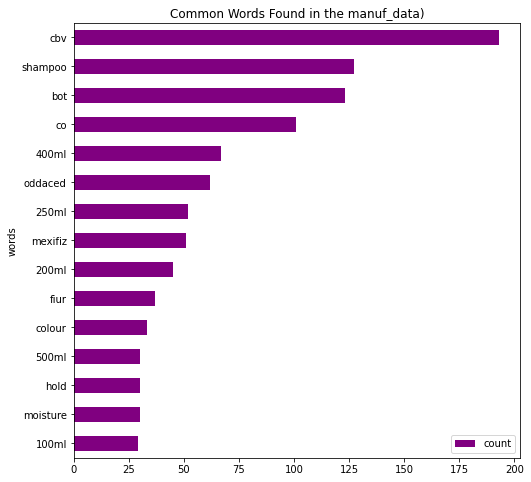

In [121]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
mnf_desc.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in the manuf_data)")

plt.show()

In [122]:
r_desc = retail['Product_Description']



In [123]:
r_desc

0                 Oddaced Give Me Moisture Shampoo 250ml
1                     Cbvery Freeze Hold Hairspray 400ml
2                       Cbvery Firm Hold Hairspray 400ml
3                  Oddaced Ultimate Hold Hairspray 400ml
4                      Cbvery Extra Hold Hairspray 400ml
                             ...                        
384    6Good Kind to Skin+ Protecting Moisture Cream ...
385    6Good Kind to Skin Vital Vitamin Day Cream SPF...
386         Toz Oil Infinite For Frizzy Hair Masque 190g
387    Twicebeaut Muru Muru Butter & Rose Blooming Co...
388          Toz Emergencée Masque For Damaged Hair 190g
Name: Product_Description, Length: 389, dtype: object

In [124]:
words_in_r_Desc = [d.lower().split() for d in r_desc]
words_in_r_Desc[:2]

[['oddaced', 'give', 'me', 'moisture', 'shampoo', '250ml'],
 ['cbvery', 'freeze', 'hold', 'hairspray', '400ml']]

In [125]:
# List of all words across tweets
r_desc_new = list(itertools.chain(*words_in_r_Desc))

# Create counter
r_desc_2 = collections.Counter(r_desc_new)

r_desc_2.most_common(15)

[('mexifiz', 104),
 ('hair', 78),
 ('for', 77),
 ('ml', 75),
 ('shampoo', 72),
 ('cbvery', 60),
 ('250ml', 55),
 ('6good', 50),
 ('parrot', 47),
 ('conditioner', 46),
 ('&', 45),
 ('fiur', 42),
 ('oddaced', 41),
 ('deodorant', 41),
 ('anti-perspirant', 38)]

In [126]:
retail_desc = pd.DataFrame(r_desc_2.most_common(15),
                             columns=['words', 'count'])

retail_desc.head()

words  count
0  mexifiz    104
1     hair     78
2      for     77
3       ml     75
4  shampoo     72

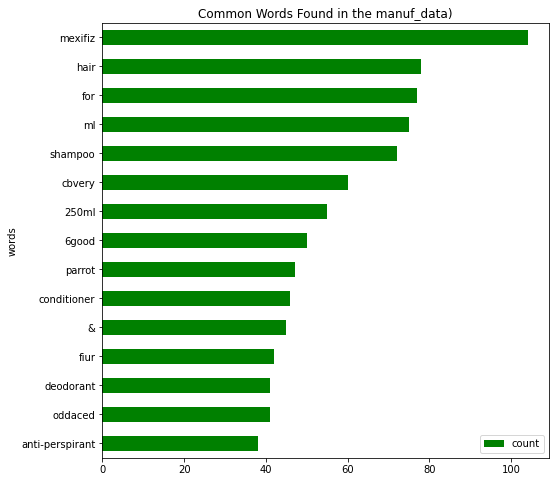

In [127]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
retail_desc.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="green")

ax.set_title("Common Words Found in the manuf_data)")

plt.show()

# Approaching different method

<font color="brown" size=+1><b>I am looking forward to implement build a document term matrix with  tf-df and n-grams, using cosine proximity between strings.
then using a hash table to convert our findings to a group column in our dataframe .</b></font>
#### The biggest challenge every strings in our mnf_data need to be compared with every strings/row with retail dataset.

In [128]:
  feature_names

['&',
 '+',
 '+ protect',
 '.',
 '100ml',
 '125ml',
 '150ml',
 '200ml',
 '235ml',
 '24',
 '24 hour',
 '250ml',
 '2in1',
 '2in1 500ml',
 '300ml',
 '30ml',
 '350ml',
 '400ml',
 '400ml bot',
 '500ml',
 '50ml',
 '6good',
 '6good co',
 '6good shampoo',
 '700ml',
 '75ml',
 '800ml',
 '900ml',
 'aero',
 'age',
 'aqspray',
 'aqspray sea',
 'aqspray spritz',
 'aqspry',
 'baby',
 'baby mexifiz',
 'balance',
 'blonde',
 'blow',
 'blow dry',
 'body',
 'body bot',
 'boost',
 'bot',
 'bot 100ml',
 'bot 200ml',
 'bot 235ml',
 'bot 250ml',
 'bot 350ml',
 'bot 400ml',
 'bot 500ml',
 'bot 50ml',
 'bot 700ml',
 'bot 800ml',
 'bot 900ml',
 'bot hydrat',
 'botanique',
 'botanique nourish',
 'care',
 'care balance',
 'care bot',
 'cbv',
 'cbv co',
 'cbv hairspray',
 'cbv heat',
 'cbv hs',
 'cbv inco',
 'cbv mousse',
 'cbv ro',
 'cbv serum',
 'cbv shampoo',
 'cbv soft',
 'cbvery',
 'cbvery hairspray',
 'clay',
 'clean',
 'cleanse',
 'cleanse &',
 'cleansing',
 'cleansing 500ml',
 'co',
 'co 24',
 'co colour',

In [129]:
!pip install sparse_dot_topn

In [130]:
# Import IGN's awesome_cossim_topn module
from sparse_dot_topn import awesome_cossim_topn

# The arguments for awesome_cossim_topn are as follows:
### 1. Our TF-IDF matrix
### 2. Our TF-IDF matrix(term doc) transposed (allowing us to build a pairwise cosine matrix)
### 3. A top_n filter, which allows us to filter the number of matches returned, which isn't useful for our purposes
### 4. This is our similarity threshold. Only values over 0.8 will be returned
cosine_matrix = awesome_cossim_topn(
  term_doc,
  term_doc.transpose(),
  Desc.size,
  0.8
)

In [131]:
cosine_matrix

<386x386 sparse matrix of type '<class 'numpy.float64'>'
	with 962 stored elements in Compressed Sparse Row format>

Let’s build our COO matrix and use it to populate our dictionary

In [132]:
coo_matrix = cosine_matrix.tocoo()

# Instaniate our lookup hash table
group_lookup = {}

def find_group(row, col):
    # If either the row or the col string have already been given
    # a group, return that group. Otherwise return none
    if row in group_lookup:
        return group_lookup[row]
    elif col in group_lookup:
        return group_lookup[col]
    else:
        return None


def add_vals_to_lookup(group, row, col):
    # Once we know the group name, set it as the value
    # for both strings in the group_lookup
    group_lookup[row] = group
    group_lookup[col] = group



def add_pair_to_lookup(row, col):
    # in this function we'll add both the row and the col to the lookup
    group = find_group(row, col)  # first, see if one has already been added
    if group is not None:
        # if we already know the group, make sure both row and col are in lookup
        add_vals_to_lookup(group, row, col)
    else:
        # if we get here, we need to add a new group.
        # The name is arbitrary, so just make it the row
        add_vals_to_lookup(row, row, col)

# for each row and column in coo_matrix
# if they're not the same string add them to the group lookup
for row, col in zip(coo_matrix.row, coo_matrix.col):
    if row != col:
        # Note that what is passed to add_pair_to_lookup is the string at each index
        # (eg: the names in the legal_name column) not the indices themselves
        add_pair_to_lookup(Desc[row], Desc[col])

In [133]:
mnf['Group'] = mnf['Description'].map(group_lookup).fillna(mnf['Description'])

mnf.to_csv('New_relation_mnf_retail.csv')

We can use various Distance calculation functions for this kind of problems.
Such as--

* Jaccard Similarity
* Different embeddings+ K-means
* Different embeddings+ Cosine Similarity
* Word2Vec + Smooth Inverse Frequency + Cosine Similarity 
* Different embeddings+LSI + Cosine Similarity 
* Different embeddings+ LDA + Jensen-Shannon distance 
* Different embeddings+ Word Mover Distance 
* Different embeddings+ Variational Auto Encoder (VAE) 
* Different embeddings+ Universal sentence encoder 
* Different embeddings+ Siamese Manhattan LSTM 
* BERT embeddings + Cosine Similarity

In [152]:
mnf_data = Desc
r_data = r_desc

In [168]:
tokenizer=nltk.tokenize.RegexpTokenizer(r'\w+')
mnf_data.apply(lambda x:tokenizer.tokenize(x))
r_data.apply(lambda x:tokenizer.tokenize(x))

0          [Oddaced, Give, Me, Moisture, Shampoo, 250ml]
1               [Cbvery, Freeze, Hold, Hairspray, 400ml]
2                 [Cbvery, Firm, Hold, Hairspray, 400ml]
3            [Oddaced, Ultimate, Hold, Hairspray, 400ml]
4                [Cbvery, Extra, Hold, Hairspray, 400ml]
                             ...                        
384    [6Good, Kind, to, Skin, Protecting, Moisture, ...
385    [6Good, Kind, to, Skin, Vital, Vitamin, Day, C...
386    [Toz, Oil, Infinite, For, Frizzy, Hair, Masque...
387    [Twicebeaut, Muru, Muru, Butter, Rose, Bloomin...
388    [Toz, Emergencée, Masque, For, Damaged, Hair, ...
Name: Product_Description, Length: 389, dtype: object

In [173]:
#def combine_text(list_of_text):
#    combined_text = ' '.join(list_of_text)
#    return combined_text

#mnf_data.apply(lambda x : combine_text(x))
#r_data.apply(lambda x : combine_text(x))

In [174]:
vectorizer = TfidfVectorizer()
def cosine_sim(text1, text2):
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]

In [178]:
Tfidf_scores = []
for i in range(len(mnf_data)):
    score = cosine_sim(mnf_data[i], r_data[i])
    Tfidf_scores.append(score)
    if i % 10000 == 0:
        progress = i/len(mnf_data) * 100
        print("Similarity Scores is {}% ".format(round(progress,2)))

Similarity Scores is 0.0% 


**need to write code in a way by which each row of the two dataset comapre each other and most similar match should be sorted as top match.**

In [190]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
data = mnf_data

def output_sentences(most_similar):
    for label, index in [('MOST', 0), ('SECOND-MOST', 1), ('MEDIAN', len(most_similar)//2), ('LEAST', len(most_similar) - 1)]:
      print(u'%s %s: %s\n' % (label, most_similar[index][1], data[int(most_similar[index][0])]))

tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data)]
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)

model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

model= Doc2Vec.load("d2v.model")
#to find the vector of a document which is not in training data
test_data = word_tokenize("I love building chatbots".lower())
v1 = model.infer_vector(test_data)
print("V1_infer", v1)

# to find most similar doc using tags
similar_doc = model.docvecs.most_similar([v1])
print(similar_doc)

# to print similar sentences
output_sentences(similar_doc) 


# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
print(model.docvecs['1'])

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning:

The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: DeprecationWarning:

Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).



iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration

In [192]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
data = r_data

def output_sentences(most_similar):
    for label, index in [('MOST', 0), ('SECOND-MOST', 1), ('MEDIAN', len(most_similar)//2), ('LEAST', len(most_similar) - 1)]:
      print(u'%s %s: %s\n' % (label, most_similar[index][1], data[int(most_similar[index][0])]))

tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data)]
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)

model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

model= Doc2Vec.load("d2v.model")
#to find the vector of a document which is not in training data
test_data = word_tokenize("I love building chatbots".lower())
v1 = model.infer_vector(test_data)
print("V1_infer", v1)

# to find most similar doc using tags
similar_doc = model.docvecs.most_similar([v1])
print(similar_doc)

# to print similar sentences
output_sentences(similar_doc) 


# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
print(model.docvecs['1'])

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning:

The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: DeprecationWarning:

Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).



iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration